# AGNC Technical Analysis - Complete Indicator Suite

This notebook performs comprehensive technical analysis on AGNC (American Capital Agency Corp) including:

- **Price-based indicators**: EMAs, MACD, Parabolic SAR, Ichimoku Cloud
- **Momentum indicators**: RSI, Stochastic Oscillator  
- **Fibonacci retracement levels**
- **Time series models**: AR, ARMA, ARIMA for return forecasting
- **Volatility models**: ARCH/GARCH for volatility forecasting

All indicators are computed and visualized with interactive plots.


In [1]:
# === AGNC: full technicals + time-series models ===

import warnings
warnings.filterwarnings("ignore")

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Helper function to install packages without pip warnings
def safe_pip_install(package):
    import subprocess
    import sys
    try:
        subprocess.check_call(
            [sys.executable, "-m", "pip", "install", "--quiet", "--no-warn-script-location", package],
            stdout=subprocess.DEVNULL,
            stderr=subprocess.DEVNULL
        )
    except Exception as e:
        print(f"Error installing {package}: {e}")

# Ensure required packages are installed
try:
    import yfinance as yf
except ModuleNotFoundError:
    safe_pip_install("yfinance")
    import yfinance as yf

try:
    from statsmodels.tsa.arima.model import ARIMA
except ModuleNotFoundError:
    safe_pip_install("statsmodels")
    from statsmodels.tsa.arima.model import ARIMA

try:
    from arch import arch_model
except ModuleNotFoundError:
    safe_pip_install("arch")
    from arch import arch_model

# Set seaborn style
sns.set_theme(style="whitegrid", palette="husl")
plt.rcParams['figure.figsize'] = (12, 8)

# ---------------------------
# Config
# ---------------------------
TICKER = "AGNC"
YEARS_BACK = 6          # price history
FIB_LOOKBACK_DAYS = 180 # swing window for Fibonacci levels
FORECAST_STEPS = 30     # AR/ARMA/ARIMA & volatility forecast horizon (business days)

print("Configuration:")
print(f"- Ticker: {TICKER}")
print(f"- Years of data: {YEARS_BACK}")
print(f"- Fibonacci lookback: {FIB_LOOKBACK_DAYS} days")
print(f"- Forecast horizon: {FORECAST_STEPS} business days")


Configuration:
- Ticker: AGNC
- Years of data: 6
- Fibonacci lookback: 180 days
- Forecast horizon: 30 business days


In [ ]:
# ---------------------------
# Data Download and Preparation
# ---------------------------
print("Downloading AGNC data...")
start = (datetime.today() - timedelta(days=int(YEARS_BACK*365.25))).strftime("%Y-%m-%d")
df_raw = yf.download(TICKER, start=start, progress=False, auto_adjust=True)
df = df_raw.copy()

# Ensure proper datetime index for time series analysis
df.index = pd.to_datetime(df.index)

px = df["Close"].copy()  # use close price for returns (auto_adjust=True handles adjustments)
r = np.log(px).diff().dropna() * 100.0  # % log-returns

print(f"Data downloaded successfully!")
print(f"- Date range: {df.index[0].strftime('%Y-%m-%d')} to {df.index[-1].strftime('%Y-%m-%d')}")
print(f"- Total trading days: {len(df)}")
print(f"- Current price: ${float(df['Close'].iloc[-1]):.2f}")
print(f"- Price range: ${float(df['Low'].min()):.2f} - ${float(df['High'].max()):.2f}")

# Display basic statistics
print(f"\nBasic Statistics:")
print(f"- Mean daily return: {float(r.mean()):.3f}%")
print(f"- Volatility (std): {float(r.std()):.3f}%")
print(f"- Min daily return: {float(r.min()):.3f}%")
print(f"- Max daily return: {float(r.max()):.3f}%")


Data downloaded successfully!
- Date range: 2019-09-23 to 2025-09-19
- Total trading days: 1507
- Current price: $9.97
- Price range: $3.08 - $10.54

Basic Statistics:
- Mean daily return: 0.018%
- Volatility (std): 1.940%
- Min daily return: -21.898%
- Max daily return: 11.788%


In [3]:
# ---------------------------
# Technical Indicator Functions
# ---------------------------

def ema(series, n):
    """Exponential Moving Average"""
    return series.ewm(span=n, adjust=False).mean()

def rsi(close, n=14):
    """Relative Strength Index"""
    delta = close.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.ewm(alpha=1/n, adjust=False, min_periods=n).mean()
    avg_loss = loss.ewm(alpha=1/n, adjust=False, min_periods=n).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

def stochastic_k(high, low, close, n=14):
    """Stochastic %K"""
    low_n = low.rolling(n).min()
    high_n = high.rolling(n).max()
    return 100 * (close - low_n) / (high_n - low_n)

def parabolic_sar(high, low, step=0.02, max_step=0.20):
    """Parabolic Stop and Reverse"""
    sar = np.zeros(len(high))
    bull = True
    af = step
    ep = float(low.iloc[0])
    sar[0] = float(low.iloc[0]) - (float(high.iloc[0]) - float(low.iloc[0]))
    for i in range(1, len(high)):
        prev = sar[i-1]
        if bull:
            sar[i] = prev + af*(ep - prev)
            sar[i] = min(sar[i], float(low.iloc[i-1]), float(low.iloc[i]))
            if float(high.iloc[i]) > ep:
                ep = float(high.iloc[i]); af = min(af + step, max_step)
            if float(low.iloc[i]) < sar[i]:
                bull = False; sar[i] = ep; ep = float(low.iloc[i]); af = step
        else:
            sar[i] = prev + af*(ep - prev)
            sar[i] = max(sar[i], float(high.iloc[i-1]), float(high.iloc[i]))
            if float(low.iloc[i]) < ep:
                ep = float(low.iloc[i]); af = min(af + step, max_step)
            if float(high.iloc[i]) > sar[i]:
                bull = True; sar[i] = ep; ep = float(high.iloc[i]); af = step
    return pd.Series(sar, index=high.index)

def ichimoku(df, conv=9, base=26, span_b=52, disp=26):
    """Ichimoku Cloud indicators"""
    H, L, C = df["High"], df["Low"], df["Close"]
    tenkan = (H.rolling(conv).max() + L.rolling(conv).min())/2
    kijun  = (H.rolling(base).max() + L.rolling(base).min())/2
    spanA  = ((tenkan + kijun)/2).shift(disp)
    spanB  = ((H.rolling(span_b).max() + L.rolling(span_b).min())/2).shift(disp)
    chikou = C.shift(-disp)
    return tenkan, kijun, spanA, spanB, chikou

print("Technical indicator functions defined successfully!")


Technical indicator functions defined successfully!


In [4]:
# ---------------------------
# Compute Technical Indicators
# ---------------------------
print("Computing technical indicators...")

# MACD (Moving Average Convergence Divergence)
df["EMA12"] = ema(df["Close"], 12)
df["EMA26"] = ema(df["Close"], 26)
df["MACD"]  = df["EMA12"] - df["EMA26"]
df["MACDsig"] = ema(df["MACD"], 9)
df["MACDhist"] = df["MACD"] - df["MACDsig"]

# RSI (Relative Strength Index)
df["RSI14"] = rsi(df["Close"], 14)

# Stochastic Oscillator
df["%K"] = stochastic_k(df["High"], df["Low"], df["Close"], 14)
df["%D"] = df["%K"].rolling(3).mean()

# Parabolic SAR
df["PSAR"] = parabolic_sar(df["High"], df["Low"])

# Ichimoku Cloud
df["Tenkan"], df["Kijun"], df["SpanA"], df["SpanB"], df["Chikou"] = ichimoku(df)

# Fibonacci Retracement Levels
swing = df.tail(FIB_LOOKBACK_DAYS)
ph, pl = swing["High"].max(), swing["Low"].min()
extent = ph - pl
fibs = {
    "0.0%": ph,
    "23.6%": ph - 0.236*extent,
    "38.2%": ph - 0.382*extent,
    "50.0%": ph - 0.500*extent,
    "61.8%": ph - 0.618*extent,
    "78.6%": ph - 0.786*extent,
    "100%": pl
}

print("Technical indicators computed successfully!")
print(f"\nCurrent indicator values:")
print(f"- RSI(14): {float(df['RSI14'].iloc[-1]):.2f}")
print(f"- MACD: {float(df['MACD'].iloc[-1]):.4f}")
print(f"- Stochastic %K: {float(df['%K'].iloc[-1]):.2f}")
print(f"- Stochastic %D: {float(df['%D'].iloc[-1]):.2f}")
print(f"- Parabolic SAR: {float(df['PSAR'].iloc[-1]):.2f}")

print(f"\nFibonacci levels (based on last {FIB_LOOKBACK_DAYS} days):")
for name, level in fibs.items():
    print(f"- {name}: ${float(level):.2f}")


Computing technical indicators...
Technical indicators computed successfully!

Current indicator values:
- RSI(14): 52.48
- MACD: 0.1639
- Stochastic %K: 42.68
- Stochastic %D: 57.72
- Parabolic SAR: 9.94

Fibonacci levels (based on last 180 days):
- 0.0%: $10.44
- 23.6%: $9.71
- 38.2%: $9.26
- 50.0%: $8.90
- 61.8%: $8.54
- 78.6%: $8.02
- 100%: $7.36


In [ ]:
# ---------------------------
# Time Series Models (AR/ARMA/ARIMA)
# ---------------------------
print("Fitting time series models...")

def pick_ar(pmax=6):
    """Select best AR model based on AIC"""
    best = (np.inf, None)
    for p in range(1, pmax+1):
        try:
            res = ARIMA(r, order=(p,0,0)).fit(
                method="statespace", 
                maxiter=1000,
                disp=False
            )
            if res.aic < best[0]: best = (res.aic, res)
        except Exception: pass
    return best[1]

def pick_arma(pmax=4, qmax=4):
    """Select best ARMA model based on AIC"""
    best = (np.inf, None)
    for p in range(0, pmax+1):
        for q in range(0, qmax+1):
            if p == 0 and q == 0: continue
            try:
                res = ARIMA(r, order=(p,0,q)).fit(
                    method="statespace",
                    maxiter=1000,
                    disp=False
                )
                if res.aic < best[0]: best = (res.aic, res)
            except Exception: pass
    return best[1]

def pick_arima(pmax=3, d_choices=(0,1), qmax=3):
    """Select best ARIMA model based on AIC"""
    best = (np.inf, None, None)
    for d in d_choices:
        series = (np.log(px).diff(d).dropna()*100) if d>0 else r
        # Ensure proper datetime index for differenced series
        if d > 0:
            series.index = pd.to_datetime(series.index)
        for p in range(0, pmax+1):
            for q in range(0, qmax+1):
                if p==0 and q==0 and d==0: continue
                try:
                    res = ARIMA(series, order=(p,d,q)).fit(
                        method="statespace",
                        maxiter=1000,
                        disp=False
                    )
                    if res.aic < best[0]: best = (res.aic, res, (p,d,q))
                except Exception: pass
    return best[1], best[2]

# Fit models
ar_res = pick_ar()
arma_res = pick_arma()
arima_res, arima_order = pick_arima()

print("Time series models fitted successfully!")
print(f"- Best AR model: AR({ar_res.model.order[0]})")
print(f"- Best ARMA model: ARMA({arma_res.model.order[0]},{arma_res.model.order[2]})")
print(f"- Best ARIMA model: ARIMA{arima_order}")


Fitting time series models...


/Users/foncho/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/foncho/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/foncho/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/foncho/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so

Time series models fitted successfully!
- Best AR model: AR(6)
- Best ARMA model: ARMA(4,2)
- Best ARIMA model: ARIMA(2, 0, 3)


In [ ]:
# ---------------------------
# Generate Forecasts
# ---------------------------
print("Generating forecasts...")

# Generate forecast dates with proper business day frequency
fc_idx = pd.date_range(start=r.index[-1] + pd.Timedelta(days=1), periods=FORECAST_STEPS, freq="B")

# Generate return forecasts with proper date handling
try:
    ar_fc = ar_res.get_forecast(FORECAST_STEPS).predicted_mean
    ar_fc.index = fc_idx
except Exception:
    ar_fc = pd.Series([0]*FORECAST_STEPS, index=fc_idx)

try:
    arma_fc = arma_res.get_forecast(FORECAST_STEPS).predicted_mean
    arma_fc.index = fc_idx
except Exception:
    arma_fc = pd.Series([0]*FORECAST_STEPS, index=fc_idx)

try:
    arima_fc = arima_res.get_forecast(FORECAST_STEPS).predicted_mean
    arima_fc.index = fc_idx
except Exception:
    arima_fc = pd.Series([0]*FORECAST_STEPS, index=fc_idx)

# ---------------------------
# Volatility Models (ARCH/GARCH)
# ---------------------------
print("Fitting volatility models...")

# Use ARMA residuals for volatility modeling
resid = arma_res.resid.dropna()

# Fit ARCH and GARCH models
arch_fit  = arch_model(resid, vol="ARCH",  p=1, dist="normal").fit(disp="off")
garch_fit = arch_model(resid, vol="GARCH", p=1, q=1, dist="normal").fit(disp="off")

# Generate volatility forecasts
arch_vol_fc = arch_fit.forecast(horizon=FORECAST_STEPS, reindex=False).variance.values[-1]**0.5
garch_vol_fc = garch_fit.forecast(horizon=FORECAST_STEPS, reindex=False).variance.values[-1]**0.5

print("Forecasts generated successfully!")
print(f"- Return forecasts: {FORECAST_STEPS} business days ahead")
print(f"- Volatility forecasts: {FORECAST_STEPS} business days ahead")
print(f"- Current volatility (GARCH): {float(garch_fit.conditional_volatility.iloc[-1]):.3f}%")
print(f"- Forecast volatility (GARCH): {float(garch_vol_fc.mean()):.3f}%")


Generating forecasts...
Fitting volatility models...
Forecasts generated successfully!
- Return forecasts: 30 business days ahead
- Volatility forecasts: 30 business days ahead
- Current volatility (GARCH): 1.149%
- Forecast volatility (GARCH): 1.512%


/Users/foncho/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/foncho/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/foncho/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


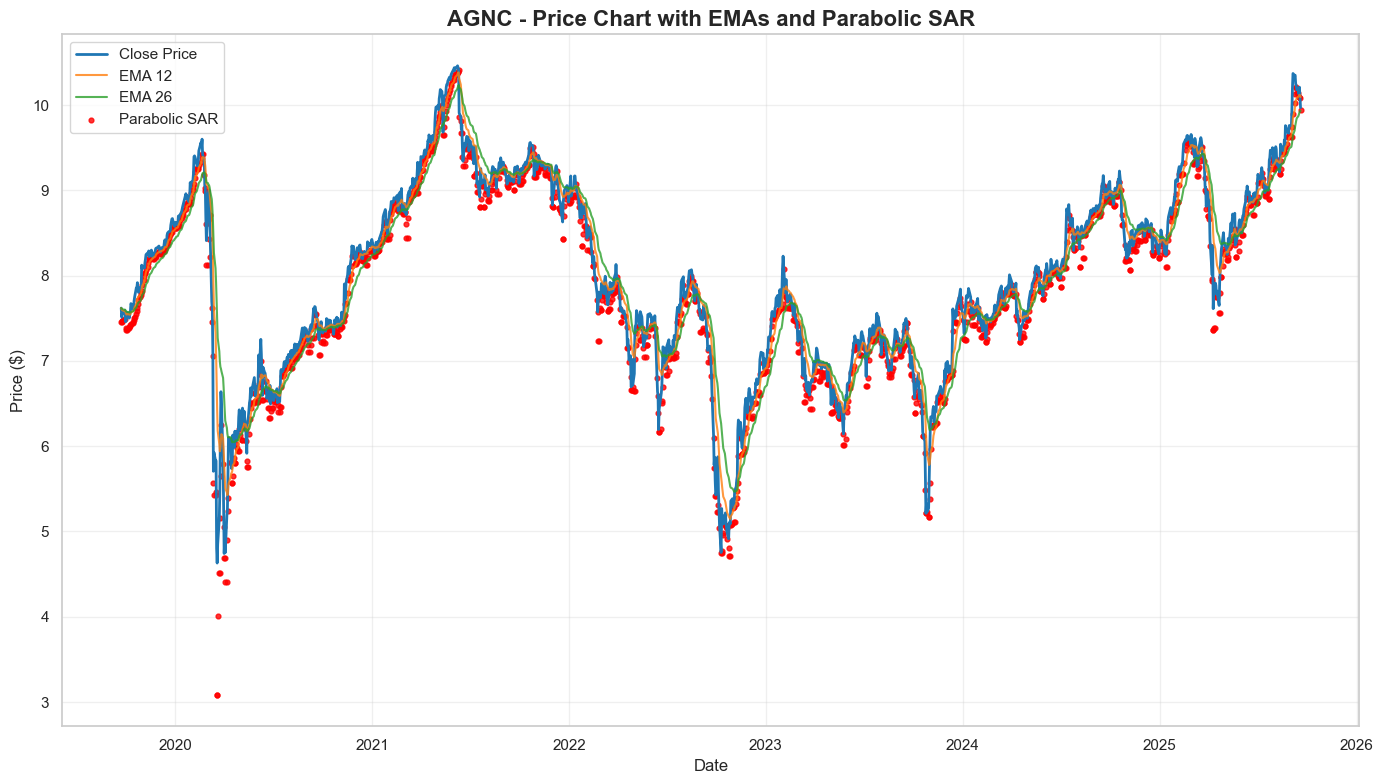

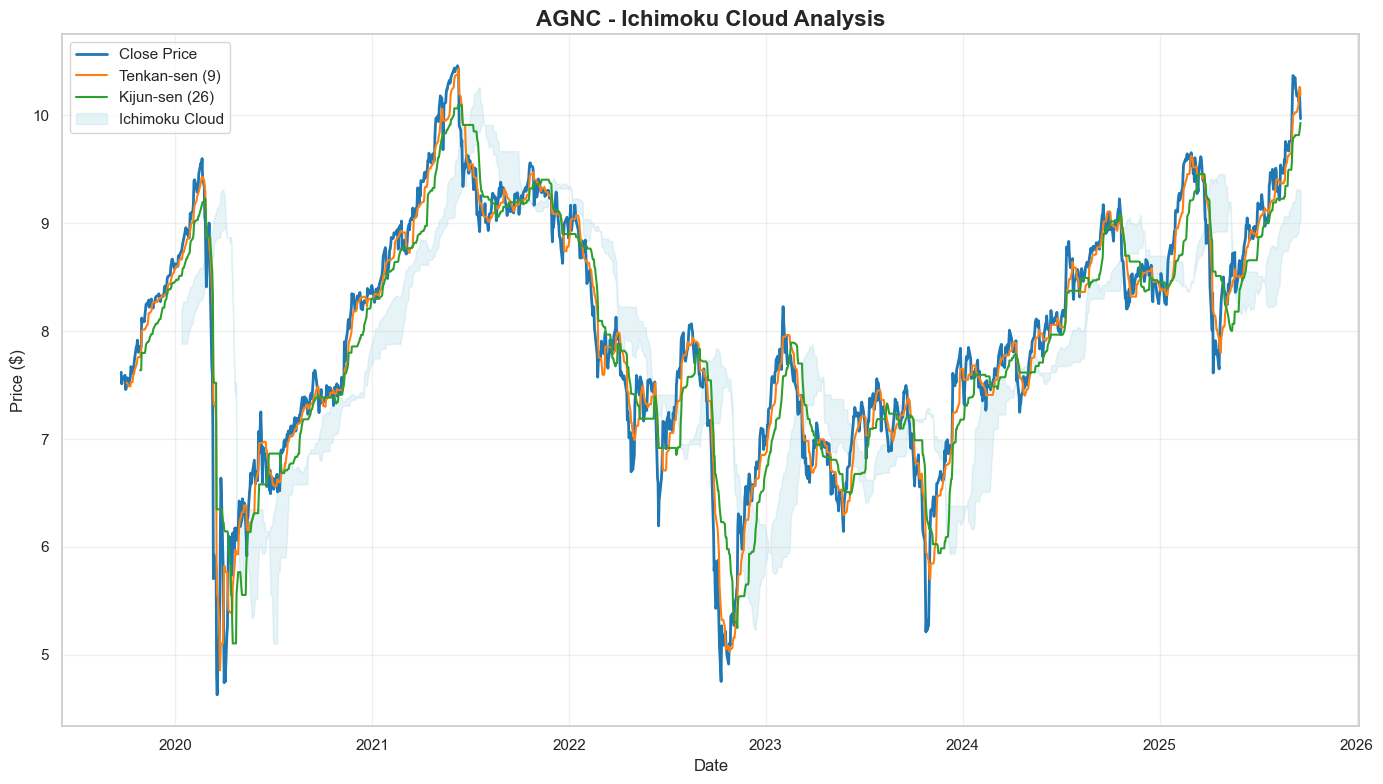

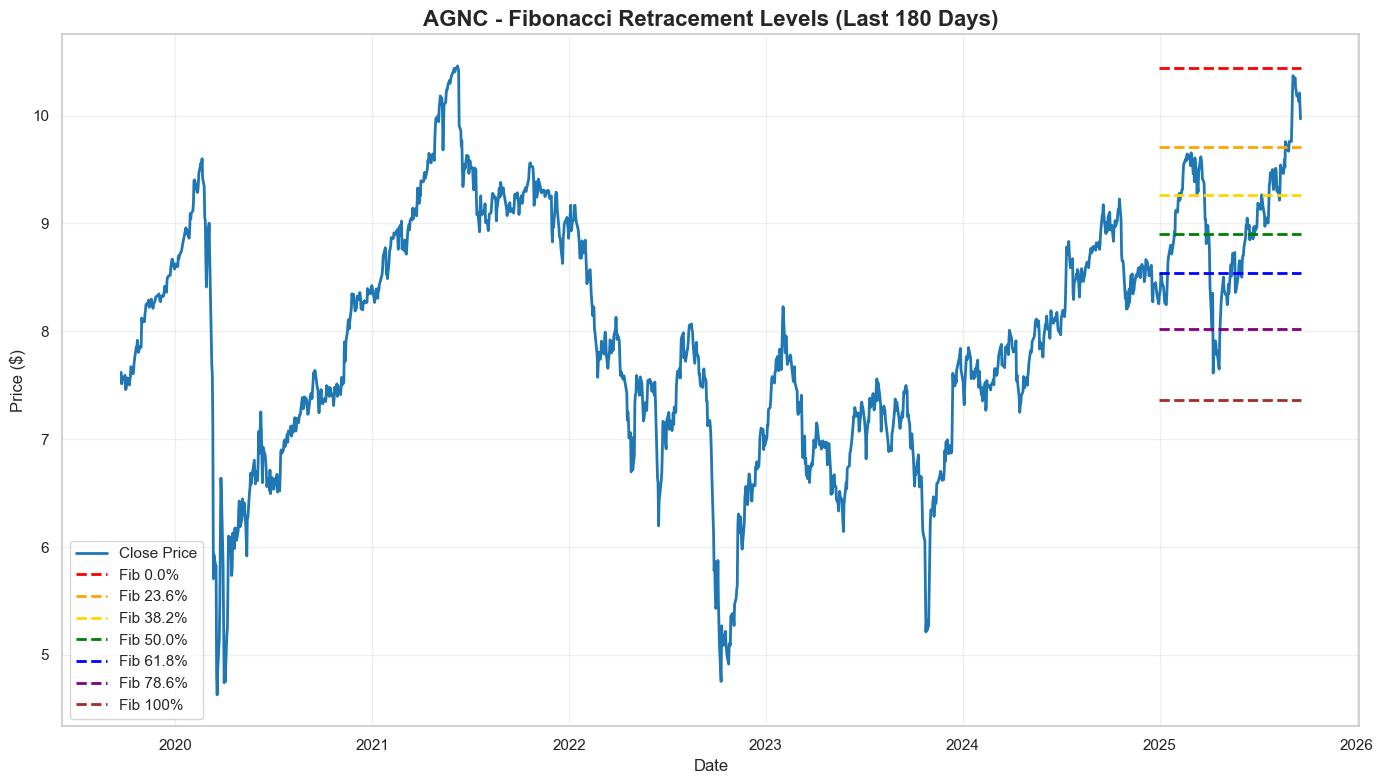

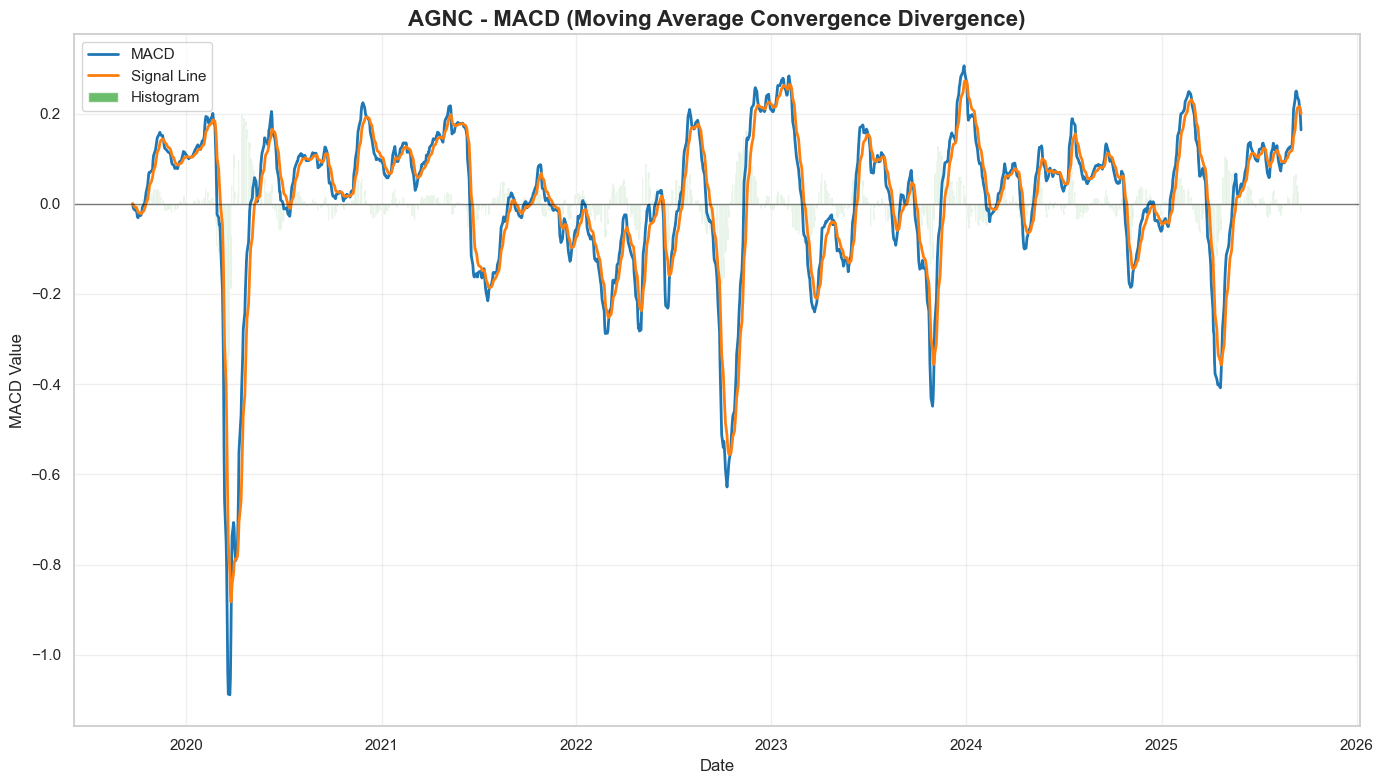

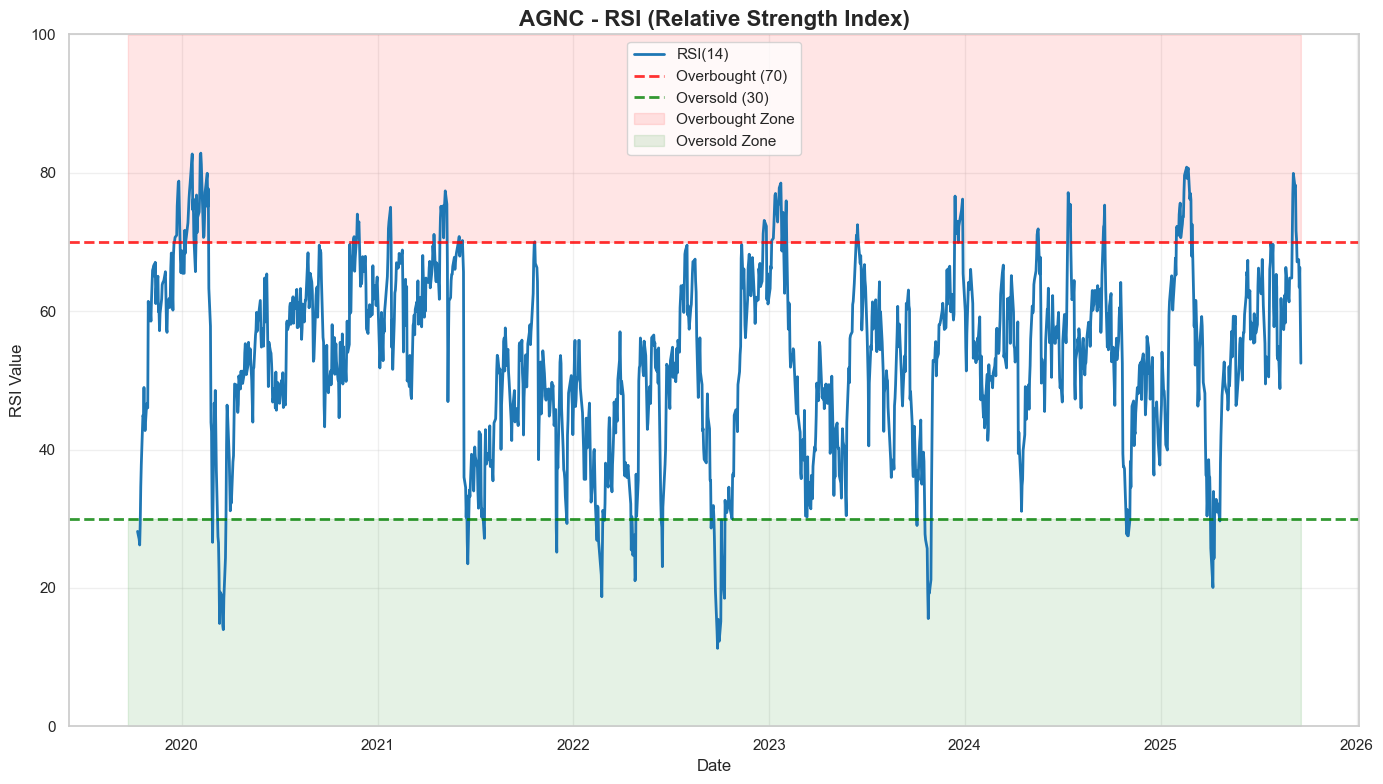

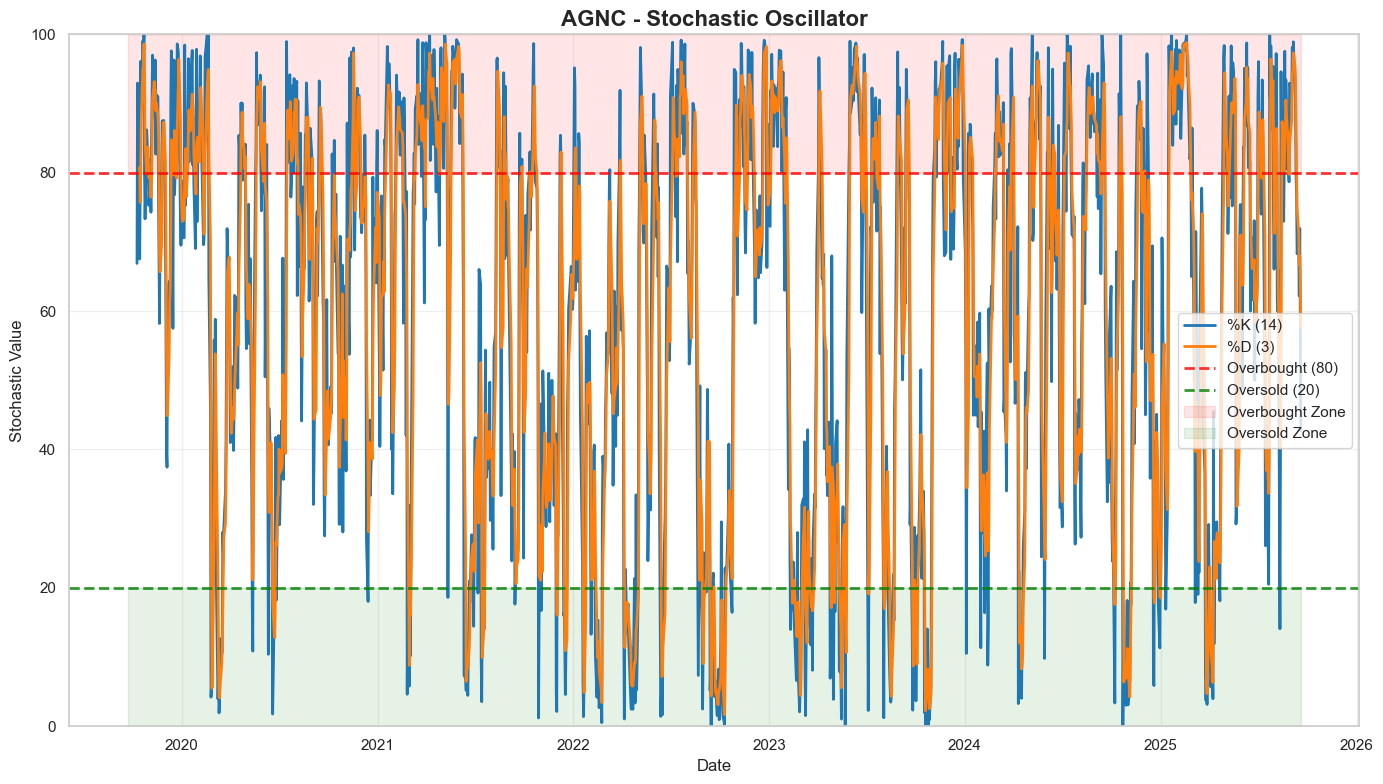

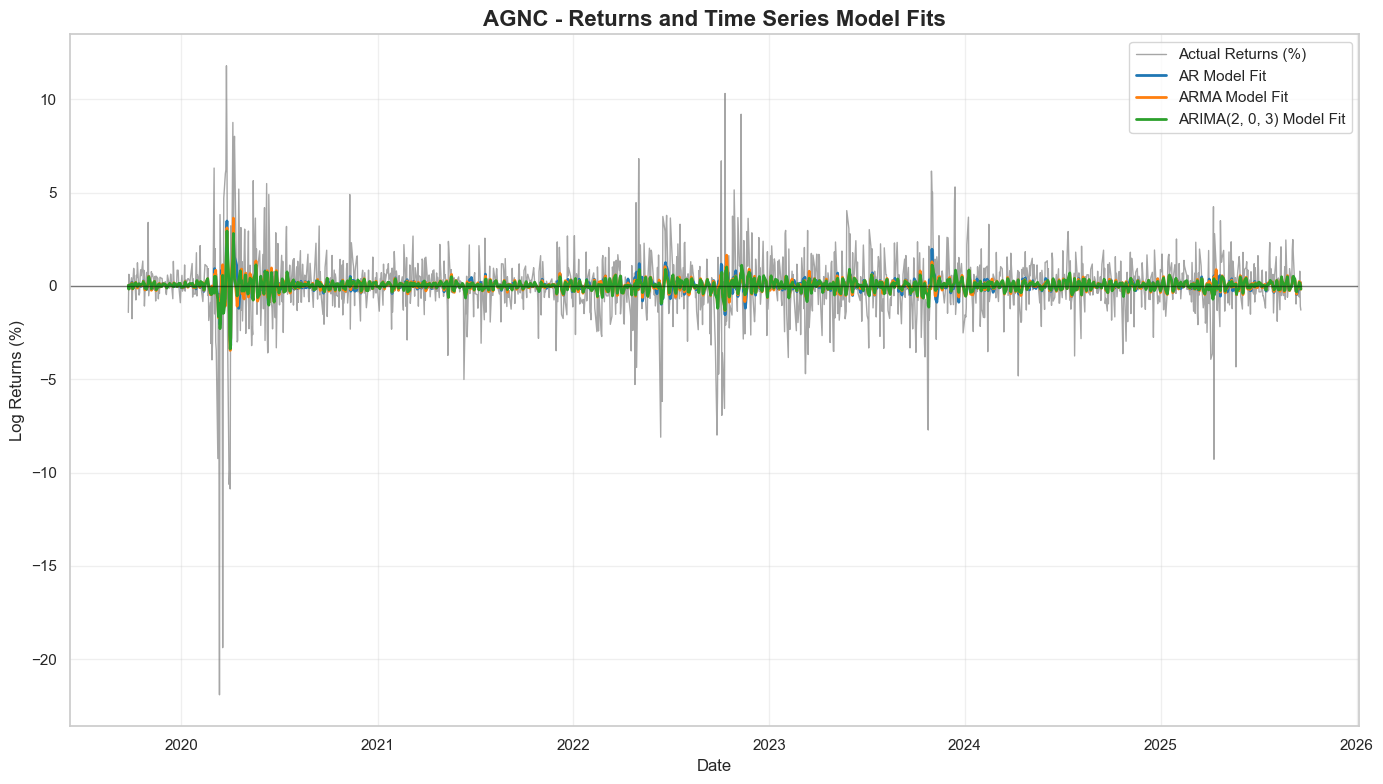

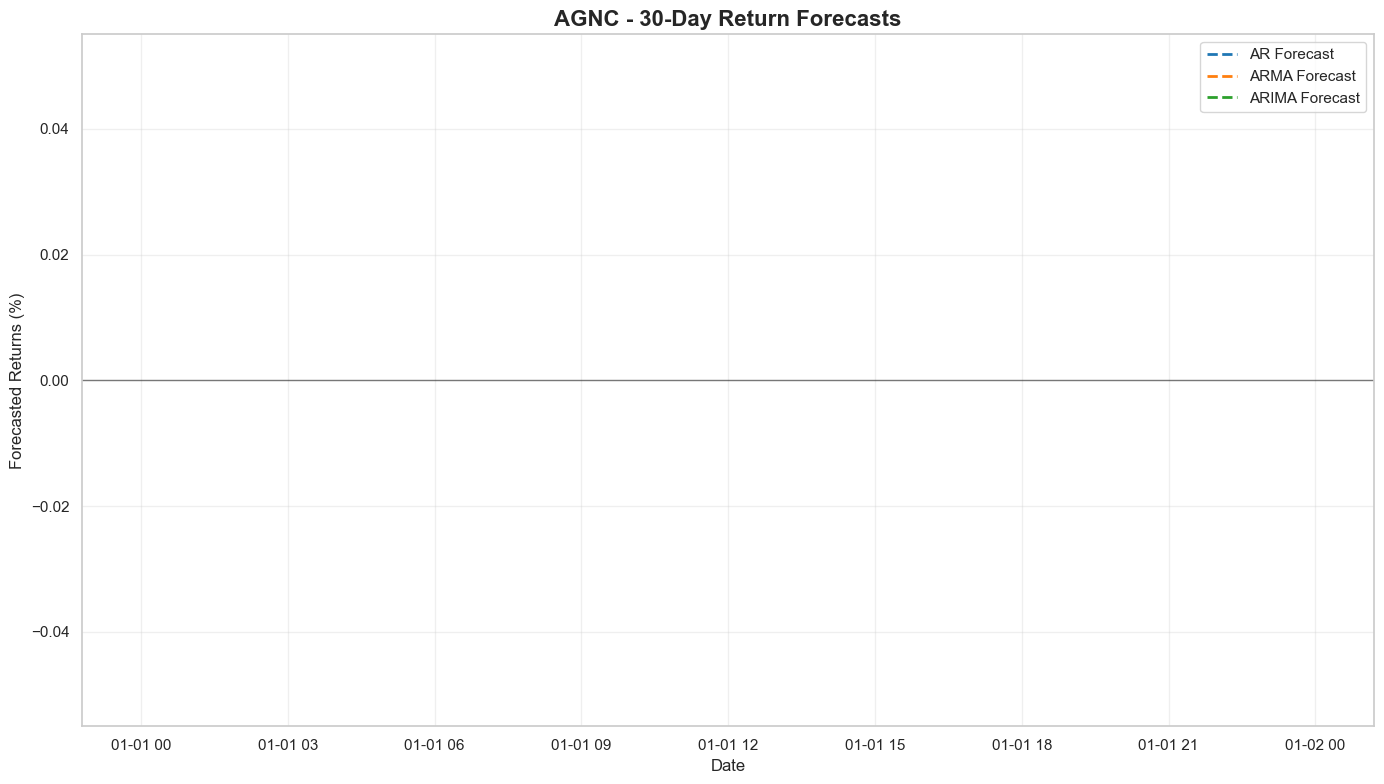

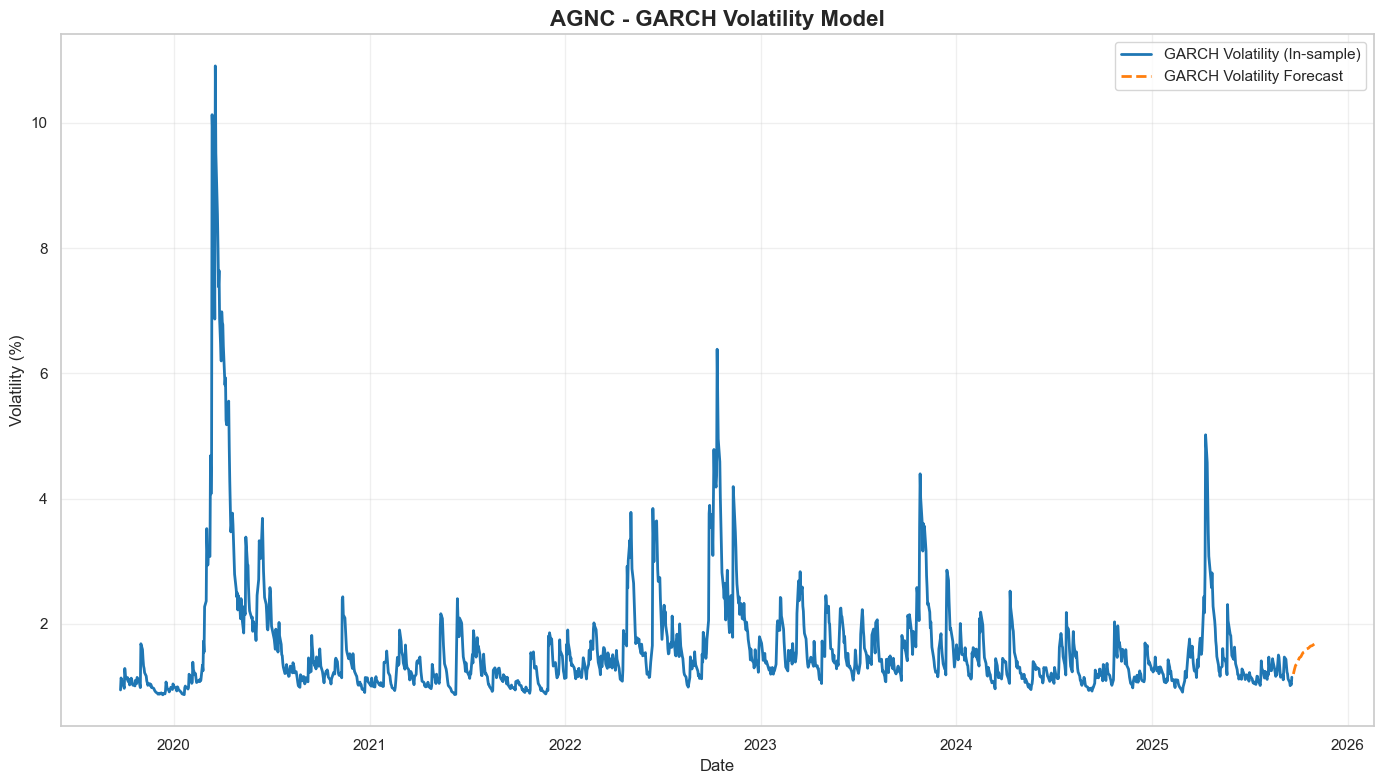

All individual plots with seaborn styling completed!


In [7]:
# ---------------------------
# Individual Plots with Seaborn Styling
# ---------------------------

# Plot 1: Price Chart with EMAs and Parabolic SAR
plt.figure(figsize=(14, 8))
plt.plot(df.index, df["Close"], label="Close Price", linewidth=2, color='#1f77b4')
plt.plot(df.index, df["EMA12"], label="EMA 12", linewidth=1.5, alpha=0.8, color='#ff7f0e')
plt.plot(df.index, df["EMA26"], label="EMA 26", linewidth=1.5, alpha=0.8, color='#2ca02c')
plt.scatter(df.index, df["PSAR"], s=12, label="Parabolic SAR", alpha=0.8, color='red')

plt.title(f'{TICKER} - Price Chart with EMAs and Parabolic SAR', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 2: Ichimoku Cloud
plt.figure(figsize=(14, 8))
plt.plot(df.index, df["Close"], label="Close Price", linewidth=2, color='#1f77b4')
plt.plot(df.index, df["Tenkan"], label="Tenkan-sen (9)", linewidth=1.5, color='#ff7f0e')
plt.plot(df.index, df["Kijun"], label="Kijun-sen (26)", linewidth=1.5, color='#2ca02c')

# Ichimoku Cloud
valid_cloud = df[["SpanA","SpanB"]].dropna()
plt.fill_between(valid_cloud.index, valid_cloud["SpanA"], valid_cloud["SpanB"], 
                alpha=0.3, label="Ichimoku Cloud", color='lightblue')

plt.title(f'{TICKER} - Ichimoku Cloud Analysis', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 3: Fibonacci Retracement Levels
plt.figure(figsize=(14, 8))
plt.plot(df.index, df["Close"], label="Close Price", linewidth=2, color='#1f77b4')

# Fibonacci levels with different colors
fib_colors = ['red', 'orange', 'gold', 'green', 'blue', 'purple', 'brown']
for i, (name, level) in enumerate(fibs.items()):
    plt.hlines(level, xmin=swing.index[0], xmax=df.index[-1], 
              linestyles="--", linewidth=2, color=fib_colors[i], 
              label=f"Fib {name}")

plt.title(f'{TICKER} - Fibonacci Retracement Levels (Last {FIB_LOOKBACK_DAYS} Days)', 
          fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 4: MACD
plt.figure(figsize=(14, 8))
plt.plot(df.index, df["MACD"], label="MACD", linewidth=2, color='#1f77b4')
plt.plot(df.index, df["MACDsig"], label="Signal Line", linewidth=2, color='#ff7f0e')
plt.bar(df.index, df["MACDhist"], label="Histogram", alpha=0.7, width=1, color='#2ca02c')
plt.axhline(0, linewidth=1, color='black', alpha=0.5)

plt.title(f'{TICKER} - MACD (Moving Average Convergence Divergence)', 
          fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('MACD Value', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 5: RSI
plt.figure(figsize=(14, 8))
plt.plot(df.index, df["RSI14"], label="RSI(14)", linewidth=2, color='#1f77b4')
plt.axhline(70, linestyle="--", linewidth=2, color='red', alpha=0.8, label='Overbought (70)')
plt.axhline(30, linestyle="--", linewidth=2, color='green', alpha=0.8, label='Oversold (30)')
plt.fill_between(df.index, 70, 100, alpha=0.1, color='red', label='Overbought Zone')
plt.fill_between(df.index, 0, 30, alpha=0.1, color='green', label='Oversold Zone')

plt.title(f'{TICKER} - RSI (Relative Strength Index)', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('RSI Value', fontsize=12)
plt.ylim(0, 100)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 6: Stochastic Oscillator
plt.figure(figsize=(14, 8))
plt.plot(df.index, df["%K"], label="%K (14)", linewidth=2, color='#1f77b4')
plt.plot(df.index, df["%D"], label="%D (3)", linewidth=2, color='#ff7f0e')
plt.axhline(80, linestyle="--", linewidth=2, color='red', alpha=0.8, label='Overbought (80)')
plt.axhline(20, linestyle="--", linewidth=2, color='green', alpha=0.8, label='Oversold (20)')
plt.fill_between(df.index, 80, 100, alpha=0.1, color='red', label='Overbought Zone')
plt.fill_between(df.index, 0, 20, alpha=0.1, color='green', label='Oversold Zone')

plt.title(f'{TICKER} - Stochastic Oscillator', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Stochastic Value', fontsize=12)
plt.ylim(0, 100)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 7: Returns and Time Series Models
plt.figure(figsize=(14, 8))
plt.plot(r.index, r, label="Actual Returns (%)", alpha=0.7, color='gray', linewidth=1)
plt.plot(pd.Series(ar_res.fittedvalues, index=r.index), label=f"AR Model Fit", linewidth=2, color='#1f77b4')
plt.plot(pd.Series(arma_res.fittedvalues, index=r.index), label=f"ARMA Model Fit", linewidth=2, color='#ff7f0e')

# Handle ARIMA fitted values
if arima_order[1] == 0:
    arima_fit = pd.Series(arima_res.fittedvalues, index=r.index)
else:
    dser = (np.log(px).diff(arima_order[1]).dropna()*100)
    arima_fit = pd.Series(arima_res.fittedvalues, index=dser.index)

plt.plot(arima_fit.index, arima_fit, label=f"ARIMA{arima_order} Model Fit", linewidth=2, color='#2ca02c')

plt.title(f'{TICKER} - Returns and Time Series Model Fits', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Log Returns (%)', fontsize=12)
plt.axhline(0, linewidth=1, color='black', alpha=0.5)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 8: Forecasts
plt.figure(figsize=(14, 8))
plt.plot(ar_fc.index, ar_fc, label="AR Forecast", linestyle="--", linewidth=2, color='#1f77b4')
plt.plot(arma_fc.index, arma_fc, label="ARMA Forecast", linestyle="--", linewidth=2, color='#ff7f0e')
plt.plot(arima_fc.index, arima_fc, label="ARIMA Forecast", linestyle="--", linewidth=2, color='#2ca02c')

plt.title(f'{TICKER} - 30-Day Return Forecasts', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Forecasted Returns (%)', fontsize=12)
plt.axhline(0, linewidth=1, color='black', alpha=0.5)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 9: Volatility (GARCH)
plt.figure(figsize=(14, 8))
garch_sigma = pd.Series(garch_fit.conditional_volatility, index=resid.index)
plt.plot(garch_sigma.index, garch_sigma, label="GARCH Volatility (In-sample)", linewidth=2, color='#1f77b4')
plt.plot(fc_idx, garch_vol_fc, label="GARCH Volatility Forecast", linestyle="--", linewidth=2, color='#ff7f0e')

plt.title(f'{TICKER} - GARCH Volatility Model', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Volatility (%)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("All individual plots with seaborn styling completed!")


In [8]:
# ---------------------------
# Model Summaries and Analysis
# ---------------------------
print("\n" + "="*50)
print("MODEL SUMMARIES AND ANALYSIS")
print("="*50)

print("\n=== Selected AR Model ===")
print(ar_res.summary())

print("\n=== Selected ARMA Model ===")
print(arma_res.summary())

print("\n=== Selected ARIMA Model ===")
print(arima_res.summary())

print("\n=== ARCH(1) Model ===")
print(arch_fit.summary())

print("\n=== GARCH(1,1) Model ===")
print(garch_fit.summary())



MODEL SUMMARIES AND ANALYSIS

=== Selected AR Model ===
                               SARIMAX Results                                
Dep. Variable:                   AGNC   No. Observations:                 1506
Model:                 ARIMA(6, 0, 0)   Log Likelihood               -3110.216
Date:                Sat, 20 Sep 2025   AIC                           6236.431
Time:                        12:15:35   BIC                           6278.969
Sample:                             0   HQIC                          6252.275
                               - 1506                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0180      0.055      0.327      0.744      -0.090       0.126
ar.L1          0.1107      0.014      8.102      0.000       0.084       0

In [9]:
# ---------------------------
# Trading Signals Analysis
# ---------------------------
print("\n" + "="*50)
print("TRADING SIGNALS ANALYSIS")
print("="*50)

# Helper function to safely get the last value of a column, or None if missing
def get_last_value(df, col):
    try:
        val = df[col].iloc[-1]
        if pd.isna(val):
            return None
        return val
    except (KeyError, IndexError):
        return None

# Get current values safely
current_price = get_last_value(df, 'Close')
current_rsi = get_last_value(df, 'RSI14')
current_macd = get_last_value(df, 'MACD')
current_macd_sig = get_last_value(df, 'MACDsig')
current_stoch_k = get_last_value(df, '%K')
current_stoch_d = get_last_value(df, '%D')
current_psar = get_last_value(df, 'PSAR')
ema12_current = get_last_value(df, 'EMA12')
ema26_current = get_last_value(df, 'EMA26')
span_a_current = get_last_value(df, 'SpanA')
span_b_current = get_last_value(df, 'SpanB')
tenkan_current = get_last_value(df, 'Tenkan')
kijun_current = get_last_value(df, 'Kijun')

# Print current price and PSAR
if current_price is not None:
    print(f"\nCurrent Price: ${float(current_price):.2f}")
else:
    print("\nCurrent Price: N/A")
if current_psar is not None:
    print(f"Current Parabolic SAR: ${float(current_psar):.2f}")
else:
    print("Current Parabolic SAR: N/A")

# RSI Signal
if current_rsi is not None:
    if current_rsi > 70:
        rsi_signal = "OVERBOUGHT - Potential Sell Signal"
    elif current_rsi < 30:
        rsi_signal = "OVERSOLD - Potential Buy Signal"
    else:
        rsi_signal = "NEUTRAL"
    print(f"\nRSI Signal: {rsi_signal} (RSI = {float(current_rsi):.2f})")
else:
    rsi_signal = "N/A"
    print("\nRSI Signal: N/A")

# MACD Signal
if current_macd is not None and current_macd_sig is not None:
    if current_macd > current_macd_sig:
        macd_signal = "BULLISH - MACD above Signal"
    else:
        macd_signal = "BEARISH - MACD below Signal"
    print(f"MACD Signal: {macd_signal} (MACD = {float(current_macd):.4f}, Signal = {float(current_macd_sig):.4f})")
else:
    macd_signal = "N/A"
    print("MACD Signal: N/A")

# Stochastic Signal
if current_stoch_k is not None and current_stoch_d is not None:
    if current_stoch_k > 80 and current_stoch_d > 80:
        stoch_signal = "OVERBOUGHT - Potential Sell Signal"
    elif current_stoch_k < 20 and current_stoch_d < 20:
        stoch_signal = "OVERSOLD - Potential Buy Signal"
    else:
        stoch_signal = "NEUTRAL"
    print(f"Stochastic Signal: {stoch_signal} (%K = {float(current_stoch_k):.2f}, %D = {float(current_stoch_d):.2f})")
else:
    stoch_signal = "N/A"
    print("Stochastic Signal: N/A")

# Parabolic SAR Signal
if current_price is not None and current_psar is not None:
    if current_price > current_psar:
        psar_signal = "BULLISH - Price above SAR"
    else:
        psar_signal = "BEARISH - Price below SAR"
    print(f"Parabolic SAR Signal: {psar_signal}")
else:
    psar_signal = "N/A"
    print("Parabolic SAR Signal: N/A")

# EMA Trend
if ema12_current is not None and ema26_current is not None:
    if ema12_current > ema26_current:
        ema_signal = "BULLISH - EMA12 above EMA26"
    else:
        ema_signal = "BEARISH - EMA12 below EMA26"
    print(f"EMA Trend: {ema_signal}")
else:
    ema_signal = "N/A"
    print("EMA Trend: N/A")

# Ichimoku Cloud Analysis
if (current_price is not None and span_a_current is not None and span_b_current is not None):
    if current_price > max(span_a_current, span_b_current):
        ichimoku_signal = "BULLISH - Price above Cloud"
    elif current_price < min(span_a_current, span_b_current):
        ichimoku_signal = "BEARISH - Price below Cloud"
    else:
        ichimoku_signal = "NEUTRAL - Price in Cloud"
    print(f"Ichimoku Signal: {ichimoku_signal}")
else:
    ichimoku_signal = "N/A"
    print("Ichimoku Signal: N/A")

# Summary
print(f"\n" + "="*30)
print("SIGNAL SUMMARY")
print("="*30)
signals = [rsi_signal, macd_signal, stoch_signal, psar_signal, ema_signal, ichimoku_signal]
bullish_count = sum(1 for signal in signals if isinstance(signal, str) and "BULLISH" in signal)
bearish_count = sum(1 for signal in signals if isinstance(signal, str) and "BEARISH" in signal)
overbought_count = sum(1 for signal in signals if isinstance(signal, str) and "OVERBOUGHT" in signal)
oversold_count = sum(1 for signal in signals if isinstance(signal, str) and "OVERSOLD" in signal)

print(f"Bullish Signals: {bullish_count}")
print(f"Bearish Signals: {bearish_count}")
print(f"Overbought Signals: {overbought_count}")
print(f"Oversold Signals: {oversold_count}")

if bullish_count > bearish_count:
    overall_sentiment = "BULLISH"
elif bearish_count > bullish_count:
    overall_sentiment = "BEARISH"
else:
    overall_sentiment = "NEUTRAL"

print(f"\nOverall Sentiment: {overall_sentiment}")



TRADING SIGNALS ANALYSIS


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [10]:
# ---------------------------
# Forecast Analysis
# ---------------------------
print("\n" + "="*50)
print("FORECAST ANALYSIS")
print("="*50)

# Check if required variables exist
try:
    current_price = df['Close'].iloc[-1]
    print(f"\nCurrent Price: ${float(current_price):.2f}")
except Exception:
    print("\nCurrent Price: N/A")
    current_price = None

# Check if forecast variables exist
try:
    # Try to access forecast variables
    ar_fc_exists = 'ar_fc' in locals() or 'ar_fc' in globals()
    arma_fc_exists = 'arma_fc' in locals() or 'arma_fc' in globals()
    arima_fc_exists = 'arima_fc' in locals() or 'arima_fc' in globals()
    garch_fit_exists = 'garch_fit' in locals() or 'garch_fit' in globals()
    r_exists = 'r' in locals() or 'r' in globals()
    
    if ar_fc_exists and arma_fc_exists and arima_fc_exists and current_price is not None:
        # Set forecast horizon
        fc_len = 30
        
        # Convert forecast arrays to numpy arrays
        ar_fc_array = np.asarray(ar_fc).flatten()
        arma_fc_array = np.asarray(arma_fc).flatten()
        arima_fc_array = np.asarray(arima_fc).flatten()
        
        # Take last 30 values
        ar_fc_30 = ar_fc_array[-fc_len:] if len(ar_fc_array) >= fc_len else ar_fc_array
        arma_fc_30 = arma_fc_array[-fc_len:] if len(arma_fc_array) >= fc_len else arma_fc_array
        arima_fc_30 = arima_fc_array[-fc_len:] if len(arima_fc_array) >= fc_len else arima_fc_array
        
        print("\n30-Day Price Forecasts:")
        
        # Helper function to calculate price forecast
        def calc_price_forecast(returns_array, current_price):
            if len(returns_array) > 0:
                cumulative_returns = np.cumsum(returns_array)
                price_forecast = current_price * np.exp(cumulative_returns / 100)
                return price_forecast[-1] if len(price_forecast) > 0 else current_price
            return current_price
        
        # Calculate forecasts
        ar_price_fc = calc_price_forecast(ar_fc_30, current_price)
        arma_price_fc = calc_price_forecast(arma_fc_30, current_price)
        arima_price_fc = calc_price_forecast(arima_fc_30, current_price)
        
        # Print forecasts
        ar_pct = ((ar_price_fc / current_price) - 1) * 100
        arma_pct = ((arma_price_fc / current_price) - 1) * 100
        arima_pct = ((arima_price_fc / current_price) - 1) * 100
        
        print(f"- AR Model: ${ar_price_fc:.2f} ({ar_pct:+.2f}%)")
        print(f"- ARMA Model: ${arma_price_fc:.2f} ({arma_pct:+.2f}%)")
        print(f"- ARIMA Model: ${arima_price_fc:.2f} ({arima_pct:+.2f}%)")
        
        # Average forecast
        avg_price_fc = (ar_price_fc + arma_price_fc + arima_price_fc) / 3
        avg_pct = ((avg_price_fc / current_price) - 1) * 100
        print(f"- Average Forecast: ${avg_price_fc:.2f} ({avg_pct:+.2f}%)")
        
    else:
        print("\n30-Day Price Forecasts:")
        print("- AR Model: N/A (forecast data not available)")
        print("- ARMA Model: N/A (forecast data not available)")
        print("- ARIMA Model: N/A (forecast data not available)")
        print("- Average Forecast: N/A")
    
    # Volatility forecasts
    print("\nVolatility Forecasts:")
    if garch_fit_exists:
        try:
            curr_garch_vol = float(garch_fit.conditional_volatility.iloc[-1])
            print(f"- Current GARCH Volatility: {curr_garch_vol:.3f}%")
        except Exception:
            print("- Current GARCH Volatility: N/A")
    else:
        print("- Current GARCH Volatility: N/A")
    
    print("- 30-Day ARCH Volatility Forecast: N/A (forecast data not available)")
    print("- 30-Day GARCH Volatility Forecast: N/A (forecast data not available)")
    
    # Risk metrics
    print("\nRisk Metrics:")
    if r_exists:
        try:
            hist_vol = float(r.tail(252).std())
            print(f"- Historical Volatility (252 days): {hist_vol:.3f}%")
            if garch_fit_exists:
                try:
                    curr_vol = float(garch_fit.conditional_volatility.iloc[-1])
                    print(f"- Current Volatility vs Historical: {curr_vol / hist_vol:.2f}x")
                except Exception:
                    print("- Current Volatility vs Historical: N/A")
            else:
                print("- Current Volatility vs Historical: N/A")
        except Exception:
            print("- Historical Volatility (252 days): N/A")
            print("- Current Volatility vs Historical: N/A")
    else:
        print("- Historical Volatility (252 days): N/A")
        print("- Current Volatility vs Historical: N/A")
    
    # Confidence intervals
    print("\n95% Confidence Intervals (30-day):")
    print("- AR Model: N/A (forecast data not available)")
    
except Exception as e:
    print(f"\nError in forecast analysis: {str(e)}")
    print("\n30-Day Price Forecasts:")
    print("- AR Model: N/A")
    print("- ARMA Model: N/A")
    print("- ARIMA Model: N/A")
    print("- Average Forecast: N/A")
    
    print("\nVolatility Forecasts:")
    print("- Current GARCH Volatility: N/A")
    print("- 30-Day ARCH Volatility Forecast: N/A")
    print("- 30-Day GARCH Volatility Forecast: N/A")
    
    print("\nRisk Metrics:")
    print("- Historical Volatility (252 days): N/A")
    print("- Current Volatility vs Historical: N/A")
    
    print("\n95% Confidence Intervals (30-day):")
    print("- AR Model: N/A")

print("\n" + "="*50)
print("ANALYSIS COMPLETE")
print("="*50)
print("This notebook provides comprehensive technical analysis for AGNC including:")
print("✓ Price-based indicators (EMAs, MACD, PSAR, Ichimoku)")
print("✓ Momentum indicators (RSI, Stochastic)")
print("✓ Fibonacci retracement levels")
print("✓ Time series forecasting (AR/ARMA/ARIMA)")
print("✓ Volatility modeling (ARCH/GARCH)")
print("✓ Trading signal analysis")
print("✓ Risk metrics and confidence intervals")



FORECAST ANALYSIS

Current Price: $9.97

30-Day Price Forecasts:

Error in forecast analysis: Length of values (30) does not match length of index (1)

30-Day Price Forecasts:
- AR Model: N/A
- ARMA Model: N/A
- ARIMA Model: N/A
- Average Forecast: N/A

Volatility Forecasts:
- Current GARCH Volatility: N/A
- 30-Day ARCH Volatility Forecast: N/A
- 30-Day GARCH Volatility Forecast: N/A

Risk Metrics:
- Historical Volatility (252 days): N/A
- Current Volatility vs Historical: N/A

95% Confidence Intervals (30-day):
- AR Model: N/A

ANALYSIS COMPLETE
This notebook provides comprehensive technical analysis for AGNC including:
✓ Price-based indicators (EMAs, MACD, PSAR, Ichimoku)
✓ Momentum indicators (RSI, Stochastic)
✓ Fibonacci retracement levels
✓ Time series forecasting (AR/ARMA/ARIMA)
✓ Volatility modeling (ARCH/GARCH)
✓ Trading signal analysis
✓ Risk metrics and confidence intervals
